# Cardiovascular Data Segmentation using K-means Clustering

In this project, we solve a binary classification problem of whether a person has a cardiovascular disease based on certain predictor variables. These solutions are usually achieved by using supervised machine learning algorithms. On the other hand, clustering is a set of unsupervised machine learning algorithms that helps in grouping subsets of data into homogenous groups. The primary function of clustering is to form groups and not classify. Thus, clustering in this project will not help directly compared to algorithms such as Logistic Regression, Random Forests, XGBoosts, etc. However, we can use this powerful algorithm to gather insights about the dataset, identify strong and weak cluster performance, and apply targetted work to improve model performance in the future.

Before starting clustering, we considered using PCA for dimensionality reduction. However, we decided against doing that. Even though PCA will help identify principal components that define the majority of the variance in data leading to better clusters, PCA will also create new aggregated features that will be hard to understand after the segmentation. In addition, there are only thirteen features in this dataset which is quite manageable for a K-means clustering algorithm. PCA would help if there were many dimensions where distance with K-means clustering loses its value. We attempted doing PCA, and it took seven principal components to explain 95% of the variance in the data. After comparing seven principal components to the original thirteen features, performing PCA before clustering was ill-advised.  

We first started by feature engineering an optimized cluster predictor variable using k-means clustering. However, performance metric analysis showed zero to negligible performance improvement using this new feature on a logistic regression model.

The team then shifted the focus to data segmentation, where after optimized clustering, we will train individual logistic regression models for each cluster to identify strong and weak performing clusters. The information can then be used to perform targetted work to improve the performance of lower-performing clusters by collecting more data concerning the given cluster and identifying other reasons that might have triggered the low performance.

In this workbook, the steps below will be followed to achieve the goals stated above. The data has already been explored and cleaned. The steps are as follows:

Step 1: Train a logistic regression model on the cleaned dataset and evaluate performance <br>
Step 2: Use k-means cluster to create segmentation on two important variables -  age and BMI <br>
Step 3: For data in each cluster, retrain logistic regression models <br>
Step 4: Evaluate performance in each cluster and compare with performance before clustering <br>


In [1]:
# Import necessary packages
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from tqdm import tqdm

import sklearn
from sklearn import metrics
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.cluster import KMeans, AgglomerativeClustering

import pandas as pd
import numpy as np
import time
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LassoCV, Ridge
from sklearn import metrics
from sklearn.model_selection import train_test_split

# Set max display of rows to 100
pd.set_option('display.max_rows', 100)

# Show all columns
pd.set_option('max_columns', None)

# Turn off scientific notation
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
# Read csv file

cardio_data = pd.read_csv("cardio_updated.csv", low_memory = False)

# Report number of rows and cols using the shape method
print("Number of Rows {}, Number of Columns {} for Cardio Data".format(cardio_data.shape[0], cardio_data.shape[1]))

Number of Rows 66801, Number of Columns 14 for Cardio Data


In [3]:
# Explore the credit purchase raw data
cardio_data.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_year,bmi
0,18393,0,168,62.00000,110,80,1,1,0,0,1,0,50,21.96712
1,20228,1,156,85.00000,140,90,3,1,0,0,1,1,55,34.92768
2,18857,1,165,64.00000,130,70,3,1,0,0,0,1,51,23.50781
3,17623,0,169,82.00000,150,100,1,1,0,0,1,1,48,28.71048
4,17474,1,156,56.00000,100,60,1,1,0,0,0,0,47,23.01118


Text(0.5, 1.0, 'heatmap of correlation matrix')

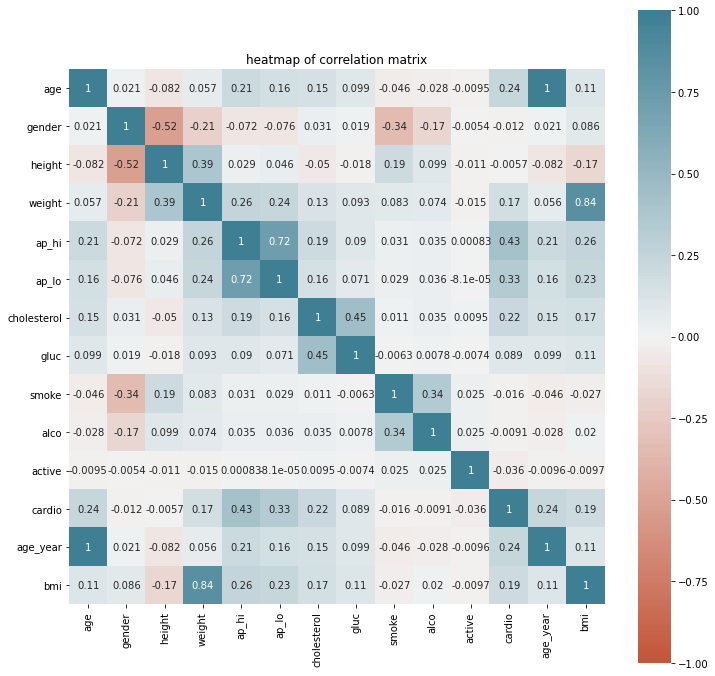

In [4]:
# Since we will be using Logistic Regression on this dataset pre and post clustering
# We would like to remove any variables that are highly correlated
# Let's get the correlation heatmap
plt.figure(figsize = (12,12))
sns.heatmap(cardio_data.corr(), vmin = -1, vmax = 1, center = 0, 
           cmap = sns.diverging_palette(20,220,n=200), square = True, annot = True, 
          ).set_title("heatmap of correlation matrix")

In [5]:
# High correlation between ap_hi and ap_lo, weight and bmi
# Engineer new features from ap and drop weight and height values since engineering BMI feature is already in the dataset

cardio_data['ap_ratio'] = cardio_data.ap_hi/cardio_data.ap_lo
cardio_data['ap_sum'] = cardio_data.ap_hi + cardio_data.ap_lo
cardio_data.drop(columns=['ap_hi', 'ap_lo','age','weight','height'], inplace = True)

Text(0.5, 1.0, 'heatmap of correlation matrix')

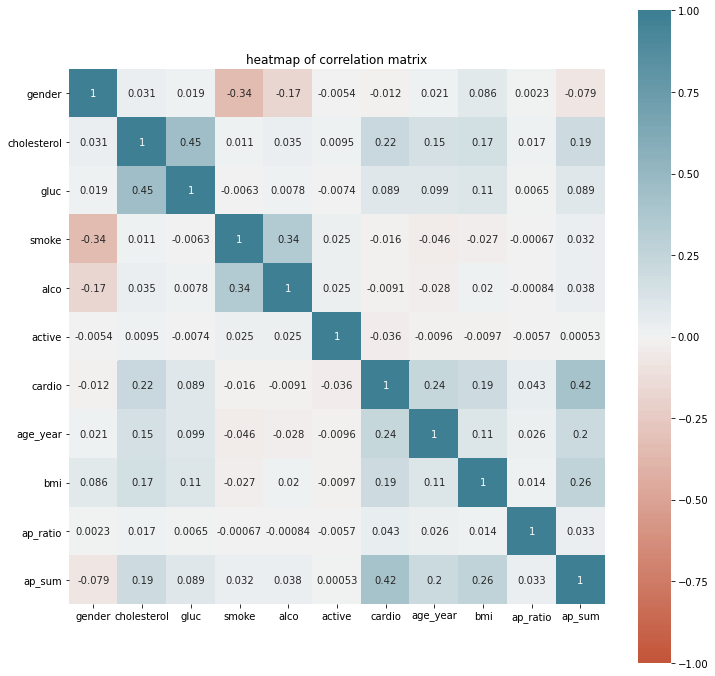

In [6]:
plt.figure(figsize = (12,12))
sns.heatmap(cardio_data.corr(), vmin = -1, vmax = 1, center = 0, 
           cmap = sns.diverging_palette(20,220,n=200), square = True, annot = True, 
          ).set_title("heatmap of correlation matrix")

<h1> Step 1 </h1>

<h2> Train a logistic regression model before clustering on the cleaned dataset and evaluate performance </h2>

In [7]:
# Split data into 70% for training, 30% for validation
train_data, val_data = train_test_split(cardio_data, test_size = 0.3, random_state = 123)

In [8]:
# Get predictor variables for training set; exclude the target variable
x_train = train_data.iloc[:, train_data.columns != "cardio"]
x_train

,gender,cholesterol,gluc,smoke,alco,active,age_year,bmi,ap_ratio,ap_sum
22856,0,1,1,0,0,0,53,29.06061,1.39241,189
24365,1,1,1,0,0,1,51,29.82325,1.50000,200
24086,1,1,1,0,0,0,51,33.17773,1.62500,210
2178,0,1,1,0,0,1,64,25.60554,1.62500,210
35477,1,1,1,0,0,1,40,25.47666,1.66667,160
...,...,...,...,...,...,...,...,...,...,...
63206,1,1,1,0,0,1,62,25.39062,1.42857,170
61404,1,1,1,0,0,1,57,24.09297,1.62500,210
17730,1,2,1,0,0,1,60,36.84424,1.71429,190
28030,0,1,1,0,0,1,64,26.12245,1.55556,230


In [9]:
# Get predictor variables for validation set; exclude the target variable

x_val = val_data.iloc[:, val_data.columns != "cardio"]
x_val

,gender,cholesterol,gluc,smoke,alco,active,age_year,bmi,ap_ratio,ap_sum
39167,0,1,1,1,1,0,61,32.65306,1.50000,200
25628,0,1,1,0,0,1,53,33.63265,1.60000,260
1830,1,1,1,0,0,1,47,29.40227,1.37500,190
66609,1,1,1,0,0,0,52,25.39062,1.50000,200
2633,1,2,1,0,0,0,56,20.50493,1.75000,220
...,...,...,...,...,...,...,...,...,...,...
40721,1,1,1,0,0,1,63,29.66655,1.50000,200
25442,0,1,1,1,0,1,62,24.50895,1.62500,210
27446,1,1,1,0,0,1,54,24.74094,1.50000,200
26314,1,1,1,0,0,1,41,34.17489,1.50000,200


In [10]:
# Understand how the target variable is distributed
train_data.cardio.value_counts()

0    23817
1    22943
Name: cardio, dtype: int64

In [11]:
# Get percentage for target variable distribution
(train_data.cardio.value_counts() / train_data.cardio.value_counts().sum())*100

0   50.93456
1   49.06544
Name: cardio, dtype: float64

In [12]:
# Standardize the training and validation sets before putting into the model
for field in x_train.columns:
    standard_dev = x_train[field].std()
    mean = x_train[field].mean()
    
    x_train[field] = (x_train[field] - mean) / standard_dev
    x_val[field] = (x_val[field] - mean) / standard_dev

<ipython-input-12-bddfbd851fe6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train[field] = (x_train[field] - mean) / standard_dev
<ipython-input-12-bddfbd851fe6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val[field] = (x_val[field] - mean) / standard_dev
<ipython-input-12-bddfbd851fe6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

In [13]:
# Train a Logistic Regression Model Pre-Clustering
logit_model = LogisticRegressionCV(random_state = 0, Cs = [0.1, 0.25, 0.5, 1, 2, 3, 5, 10, 50, 100]).fit(x_train, train_data.cardio)

In [14]:
# Get optimal value for cross-validation parameter C
c_value_original = []
c_value_original.append(logit_model.C_)
logit_model.C_

array([0.1])

In [15]:
# Get predicted probabilities for trainining and validation sets - this will be used to calculate AUC values
y_train_prob = logit_model.predict_proba(x_train)
y_val_prob = logit_model.predict_proba(x_val)

In [16]:
# Get predictions for trainining and validation sets - this will be used to calculate accuracy-scores
y_train_pred = logit_model.predict(x_train)
y_val_pred = logit_model.predict(x_val)

In [17]:
# Get precision-score on the training data and add to a list that will be used for a summary table later in the notebook
precision_score_train_original = []
precision_score_train_original.append(metrics.precision_score(train_data.cardio, y_train_pred))
print("Precision for training data - ", metrics.precision_score(train_data.cardio, y_train_pred))

Precision for training data -  0.7509405940594059


In [18]:
# Get recision-score on the validation data and add to a list that will be used for a summary table later in the notebook
precision_score_val_original = []
precision_score_val_original.append(metrics.precision_score(val_data.cardio, y_val_pred))
print("Precision for validation data - ", metrics.precision_score(val_data.cardio, y_val_pred))

Precision for validation data -  0.7527247158092113


In [19]:
# Get recall-score on the training data and add to a list that will be used for a summary table later in the notebook
recall_score_train_original = []
recall_score_train_original.append(metrics.recall_score(train_data.cardio, y_train_pred))
print("Recall for training data - ", metrics.recall_score(train_data.cardio, y_train_pred))

Recall for training data -  0.6611602667480277


In [20]:
# Get recall-score on the validation data and add to a list that will be used for a summary table later in the notebook
recall_score_val_original = []
recall_score_val_original.append(metrics.recall_score(val_data.cardio, y_val_pred))
print("Recall for validation data - ", metrics.recall_score(val_data.cardio, y_val_pred))

Recall for validation data -  0.6596487624525008


In [21]:
# Get accuracy-score on the training data and add to a list that will be used for a summary table later in the notebook
accuracy_score_train_original = []
accuracy_score_train_original.append(metrics.accuracy_score(train_data.cardio, y_train_pred))
print("Accuracy for training data - ", metrics.accuracy_score(train_data.cardio, y_train_pred))

Accuracy for training data -  0.7261548331907614


In [22]:
# Get accuracy-score on the validation data and add to a list that will be used for a summary table later in the notebook
accuracy_score_val_original = []
accuracy_score_val_original.append(metrics.accuracy_score(val_data.cardio, y_val_pred))
print("Accuracy for validation data - ", metrics.accuracy_score(val_data.cardio, y_val_pred))

Accuracy for validation data -  0.729354822613642


In [23]:
# Get f1-score on the training data and add to a list that will be used for a summary table later in the notebook
f1_score_train_original = []
f1_score_train_original.append(metrics.f1_score(train_data.cardio, y_train_pred))
print("F1-Score for training data - ", metrics.f1_score(train_data.cardio, y_train_pred))

F1-Score for training data -  0.7031963470319635


In [24]:
# Get f1-score on the validation data and add to a list that will be used for a summary table later in the notebook
f1_score_val_original = []
f1_score_val_original.append(metrics.f1_score(val_data.cardio, y_val_pred))
print("F1-Score for validation data - ", metrics.f1_score(val_data.cardio, y_val_pred))

F1-Score for validation data -  0.7031198686371101


In [25]:
# Get AUC on the training data and add to a list that will be used for a summary table later in the notebook
auc_train_original = []
fpr_train, tpr_train, thresholds_train = metrics.roc_curve(train_data.cardio, y_train_prob[:,1], pos_label = 1)
auc_train_original.append(metrics.auc(fpr_train, tpr_train))
print("AUC for training data - ", metrics.auc(fpr_train, tpr_train))

AUC for training data -  0.788951684766154


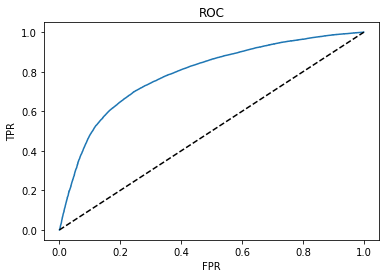

In [26]:
# Plot ROC on training dataset
plt.plot(fpr_train, tpr_train)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot([0, 1], [0, 1], color = 'black', linestyle = "dashed")
plt.title("ROC")
plt.show()

In [27]:
# Get AUC on the validation data and add to a list that will be used for a summary table later in the notebook
auc_val_original = []
fpr_val, tpr_val, thresholds_val = metrics.roc_curve(val_data.cardio, y_val_prob[:,1], pos_label = 1)
auc_val_original.append(metrics.auc(fpr_val, tpr_val))
print("AUC for validation data - ", metrics.auc(fpr_val, tpr_val))

AUC for validation data -  0.7925727295575499


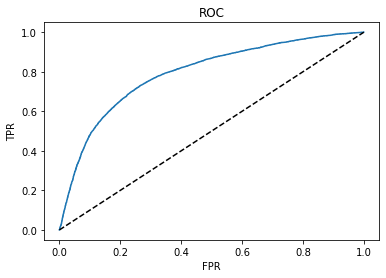

In [28]:
# Plot ROC on validation dataset
plt.plot(fpr_val, tpr_val)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot([0, 1], [0, 1], color = 'black', linestyle = "dashed")
plt.title("ROC")
plt.show()

In [29]:
# Create a summary table for pre-clustering data that includes auc and performance metrics vs. each of the six clusters



pre_clustering_performance = pd.DataFrame({'Training' : 
                                        {'Accuracy'        : metrics.accuracy_score(train_data.cardio, y_train_pred),
                                         'Precision'       : metrics.precision_score(train_data.cardio, y_train_pred),
                                         'Recall'          : metrics.recall_score(train_data.cardio, y_train_pred),
                                         'F1-Score'        : metrics.f1_score(train_data.cardio, y_train_pred),
                                         'AUC'             : metrics.auc(fpr_train, tpr_train)},
                       
                                        'Validation'  : 
                                        {'Accuracy'        : metrics.accuracy_score(val_data.cardio, y_val_pred),
                                         'Precision'       : metrics.precision_score(val_data.cardio, y_val_pred),
                                         'Recall'          : metrics.recall_score(val_data.cardio, y_val_pred),
                                         'F1-Score'        : metrics.f1_score(val_data.cardio, y_val_pred),
                                         'AUC'             : metrics.auc(fpr_val, tpr_val)}
                                         })


pre_clustering_performance.style.set_table_attributes("style='display:inline'").set_caption('a')


# Display the pre-clustering summary table
print("Pre-Clustering Summary Table")
display(pre_clustering_performance)



Pre-Clustering Summary Table


,Training,Validation
Accuracy,0.72615,0.72935
Precision,0.75094,0.75272
Recall,0.66116,0.65965
F1-Score,0.70320,0.70312
AUC,0.78895,0.79257


<h1> Step 2 </h1>

<h2> Use k-means cluster to create segmentation on two important variables - age and bmi  </h2>

In [30]:
# Drop target variable before clustering

cardio_data_cluster = cardio_data.drop(columns = ["cardio"])
cardio_data_cluster

,gender,cholesterol,gluc,smoke,alco,active,age_year,bmi,ap_ratio,ap_sum
0,0,1,1,0,0,1,50,21.96712,1.37500,190
1,1,3,1,0,0,1,55,34.92768,1.55556,230
2,1,3,1,0,0,0,51,23.50781,1.85714,200
3,0,1,1,0,0,1,48,28.71048,1.50000,250
4,1,1,1,0,0,0,47,23.01118,1.66667,160
...,...,...,...,...,...,...,...,...,...,...
66796,1,1,1,0,0,1,57,29.38476,1.87500,230
66797,0,1,1,1,0,1,52,26.92744,1.50000,200
66798,0,3,1,0,1,0,52,31.35358,2.00000,270
66799,1,1,2,0,0,0,61,27.09925,1.68750,215


In [31]:
# Scale dataset between 0 and 1 before clustering (normalization)

scaled_data = (cardio_data_cluster - cardio_data_cluster.min()) / (cardio_data_cluster.max() - cardio_data_cluster.min())

scaled_data



,gender,cholesterol,gluc,smoke,alco,active,age_year,bmi,ap_ratio,ap_sum
0,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.60000,0.51001,0.00245,0.46328
1,1.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.74286,0.86741,0.00385,0.57627
2,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.62857,0.55250,0.00619,0.49153
3,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.54286,0.69596,0.00342,0.63277
4,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.51429,0.53880,0.00471,0.37853
...,...,...,...,...,...,...,...,...,...,...
66796,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.80000,0.71456,0.00633,0.57627
66797,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.65714,0.64680,0.00342,0.49153
66798,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000,0.65714,0.76885,0.00730,0.68927
66799,1.00000,0.00000,0.50000,0.00000,0.00000,0.00000,0.91429,0.65153,0.00488,0.53390


In [32]:
# Run K-means clustering for k values between 2 and 15
# Calculate inertia and the Silhouette score for each value of k

k_values = range(2, 16) # range function to setup k values from 2 to 15

# empty lists to capture inertia and silhouette value for each model with diffent k values
inertias = []
silhouettes = []

# for loop to go through each k value, fit a cluster model and report inertia and silhouette values
# tqdm used to see task progress and run time - we can see the loop ran 14 times for the 14 values
# total runtime was about 2 minutes per k-value

for k in tqdm(k_values):
    
    # fit cluster model 
    cluster_model = KMeans(n_clusters = k, random_state = 0).fit(scaled_data)
    
    # print inertia and silhouette values
    print("Inertia with k = {} is {}".format(k,cluster_model.inertia_))
    print("Silhouette score with k = {} is {}".format(k,metrics.silhouette_score(scaled_data, labels = cluster_model.labels_)))
    
    # append current inertia and silhouette values to global lists
    inertias.append(cluster_model.inertia_)
    silhouettes.append(metrics.silhouette_score(scaled_data, labels = cluster_model.labels_))


  0%|          | 0/14 [00:00<?, ?it/s]

Inertia with k = 2 is 35292.94305385469
Silhouette score with k = 2 is 0.3801914492951291


  7%|▋         | 1/14 [02:56<38:19, 176.86s/it]

Inertia with k = 3 is 27831.059540673865
Silhouette score with k = 3 is 0.4230348448762537


 14%|█▍        | 2/14 [05:31<34:01, 170.13s/it]

Inertia with k = 4 is 23094.907519536988
Silhouette score with k = 4 is 0.434172058841683


 21%|██▏       | 3/14 [07:58<29:56, 163.28s/it]

Inertia with k = 5 is 19026.392311964937
Silhouette score with k = 5 is 0.4611065215260776


 29%|██▊       | 4/14 [10:27<26:28, 158.89s/it]

Inertia with k = 6 is 16488.004250843896
Silhouette score with k = 6 is 0.49847229489682093


 36%|███▌      | 5/14 [12:37<22:32, 150.32s/it]

Inertia with k = 7 is 14690.848592717828
Silhouette score with k = 7 is 0.4707531484128922


 43%|████▎     | 6/14 [14:30<18:31, 138.97s/it]

Inertia with k = 8 is 13472.837067906205
Silhouette score with k = 8 is 0.480255398216942


 50%|█████     | 7/14 [16:13<14:59, 128.45s/it]

Inertia with k = 9 is 12267.52662775173
Silhouette score with k = 9 is 0.4928620343574758


 57%|█████▋    | 8/14 [18:04<12:17, 122.99s/it]

Inertia with k = 10 is 11624.784529595998
Silhouette score with k = 10 is 0.3980739495473743


 64%|██████▍   | 9/14 [19:50<09:49, 117.98s/it]

Inertia with k = 11 is 10850.789518913447
Silhouette score with k = 11 is 0.4107958232011532


 71%|███████▏  | 10/14 [21:32<07:32, 113.17s/it]

Inertia with k = 12 is 10307.639847690507
Silhouette score with k = 12 is 0.41780387501954086


 79%|███████▊  | 11/14 [23:18<05:32, 110.90s/it]

Inertia with k = 13 is 9929.178863248486
Silhouette score with k = 13 is 0.36099237879334367


 86%|████████▌ | 12/14 [25:01<03:37, 108.67s/it]

Inertia with k = 14 is 9184.837485765569
Silhouette score with k = 14 is 0.3762999014036244


 93%|█████████▎| 13/14 [26:47<01:47, 107.84s/it]

Inertia with k = 15 is 8681.179536209153
Silhouette score with k = 15 is 0.38432071261269357


100%|██████████| 14/14 [28:29<00:00, 122.14s/it]


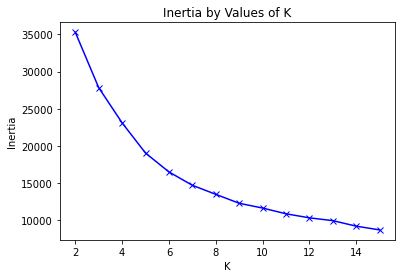

In [33]:
# Elbow method to find optimal value of k
# We plot the inertia values agains the corresponding k values
# We look for a sharp change in slope of the graph which seems to be at k = 6
# k = 6 is optimal value according to the elbow method

plt.plot(k_values, inertias, 'bx-') # plot k values on x axis, inertias on y
plt.xlabel('K') 
plt.ylabel('Inertia')
plt.title('Inertia by Values of K')
plt.show()

In [34]:
# Silhouette score is an alternative method to finding the optimal k value
# The silhouette score has a range between -1 and 1
# The closer the value is to 1, the better the clusters in the sense that  the sample is far away from the neighboring clusters
# Therefore, the corresponding k value to the highest silhouette score is our optimal k value using this method
# k = 6 is the optimal value according to the Silhouette method as well

silhouette_k = pd.DataFrame(zip(k_values, silhouettes))
silhouette_k.columns = ["k_value","silhouette score"]

display(silhouette_k.style.hide_index())

k_value,silhouette score
2,0.380191
3,0.423035
4,0.434172
5,0.461107
6,0.498472
7,0.470753
8,0.480255
9,0.492862
10,0.398074
11,0.410796


In [35]:
# Since there is no differnce in the optimal k value reported by the elbow method and silhoutte method,
# the k-means cluster will be reconstructed using k = 6
# If there had been a difference between the two methods, we would evaluate a trade-off between business judgement and data science

# run k-means with k = 6
cluster_model = KMeans(n_clusters = 6, random_state = 0).fit(scaled_data)

In [37]:
# Select the two dimensions for the clustering analysis. The two variables - bmi and age_years - are used.
# The idea is to create clusters based on a person's bmi and age in years
# With the new clusters, new logistic regression models will be trained to check whether certain clusters perform better than others
# The analysis can then be used to do targetted data collection or analysis for people in specific clusters

X = scaled_data.iloc[:, [6,7]].values

In [38]:
# Create y values for the clusters 

y_kmeans = cluster_model.fit_predict(X)
y_kmeans

array([1, 3, 1, ..., 3, 4, 4], dtype=int32)

In [39]:
cluster_model.labels_

array([1, 3, 1, ..., 3, 4, 4], dtype=int32)

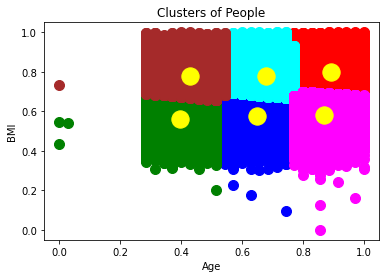

In [40]:
# Plot all 6 clusters in a two-dimensional scatter plot
plt.scatter(X[y_kmeans==0, 0], X[y_kmeans==0, 1], s=100, c='red', label ='Cluster 0')
plt.scatter(X[y_kmeans==1, 0], X[y_kmeans==1, 1], s=100, c='blue', label ='Cluster 1')
plt.scatter(X[y_kmeans==2, 0], X[y_kmeans==2, 1], s=100, c='green', label ='Cluster 2')
plt.scatter(X[y_kmeans==3, 0], X[y_kmeans==3, 1], s=100, c='cyan', label ='Cluster 3')
plt.scatter(X[y_kmeans==4, 0], X[y_kmeans==4, 1], s=100, c='magenta', label ='Cluster 4')
plt.scatter(X[y_kmeans==5, 0], X[y_kmeans==5, 1], s=100, c='brown', label ='Cluster 5')

#Plot the centroid using the cluster centres method
plt.scatter(cluster_model.cluster_centers_[:, 0], cluster_model.cluster_centers_[:, 1], s=300, c='yellow', label = 'Centroids')

# Add plot title, and axes labels
plt.title('Clusters of People')
plt.xlabel('Age')
plt.ylabel('BMI')

# Display scatter plot
plt.show()

<h3> The clusters can be defined as follows: </h3>

Cluster 0 - Red - Older Population with High BMI <br>
Cluster 1 - Blue - Middle-Aged Population with Low BMI <br>
Cluster 2 - Green - Younger Population with Low BMI <br>
Cluster 3 - Cyan - Middle-Aged Population with High BMI <br>
Cluster 4 - Magenta - Older Population with Low BMI <br>
Cluster 5 - Browmn - Younger Population with High BMI <br>

In [41]:
# Add cluster label to the original dataset
# The cluster variable will be used as a new feature added to the original dataset

cardio_data_with_cluster = cardio_data
cardio_data_with_cluster["kmeans_cluster"] = cluster_model.fit_predict(X)
cardio_data_with_cluster.head()

,gender,cholesterol,gluc,smoke,alco,active,cardio,age_year,bmi,ap_ratio,ap_sum,kmeans_cluster
0,0,1,1,0,0,1,0,50,21.96712,1.37500,190,1
1,1,3,1,0,0,1,1,55,34.92768,1.55556,230,3
2,1,3,1,0,0,0,1,51,23.50781,1.85714,200,1
3,0,1,1,0,0,1,1,48,28.71048,1.50000,250,5
4,1,1,1,0,0,0,0,47,23.01118,1.66667,160,2


In [42]:
# Finding the mean of each column grouped by the cluster label
# Note the age_year and bmi columns.
# The mean values for these two variables match the clusters that were found and defined above
# For example, Cluster 0 was defined as older population with High BMI
# The mean values are compatible since cluster 0 sees the maximum values for both of them at 60.22 years for the age and 32.48 years for the bmi
# Also notice the bloodpressure (ap_hi and ap_lo), cholestrol and cardio target variable all have max values for this cluster

cardio_data_with_cluster.groupby(cardio_data_with_cluster.kmeans_cluster).mean()

,gender,cholesterol,gluc,smoke,alco,active,cardio,age_year,bmi,ap_ratio,ap_sum
kmeans_cluster,,,,,,,,,,,
0,0.71549,1.64652,1.38695,0.06141,0.05014,0.79285,0.69270,60.21974,32.48671,1.59287,219.14010
1,0.63801,1.26894,1.17637,0.09100,0.04973,0.80258,0.40471,51.69355,24.35195,1.55664,203.45311
2,0.59114,1.17492,1.11776,0.11114,0.05697,0.81175,0.27702,42.91207,23.89623,1.54997,196.89576
3,0.71064,1.44839,1.27378,0.08400,0.06095,0.80820,0.56740,52.76326,31.79878,1.56944,214.25819
4,0.61142,1.37554,1.22575,0.08312,0.04526,0.80404,0.56846,59.47655,24.62744,1.57844,208.37657
5,0.65852,1.32693,1.19612,0.10748,0.07315,0.80724,0.47751,44.01400,31.62868,1.54718,208.54656


In [43]:
cardio_data_with_cluster.groupby(cardio_data_with_cluster.kmeans_cluster).mean()["age_year"]

kmeans_cluster
0   60.21974
1   51.69355
2   42.91207
3   52.76326
4   59.47655
5   44.01400
Name: age_year, dtype: float64

In [44]:
cardio_data_with_cluster.groupby(cardio_data_with_cluster.kmeans_cluster).mean()["bmi"]

kmeans_cluster
0   32.48671
1   24.35195
2   23.89623
3   31.79878
4   24.62744
5   31.62868
Name: bmi, dtype: float64

In [45]:
# Here we start analyzing the target variable with respect to the clusters
# We first start by looking at the number of observations in each cluster
# Looks like clusters 1 and 4 have the most observations while cluster 5 has the least
cardio_data_with_cluster['kmeans_cluster'].value_counts()

1    16528
4    16483
2    10725
3     9369
0     8337
5     5359
Name: kmeans_cluster, dtype: int64

In [46]:
# The table below shows a pivot table between the clusters and the count of cardio cases within those clusters

dframe = pd.DataFrame()
dframe["Cluster"] = cardio_data_with_cluster["kmeans_cluster"]
dframe["HasCardioDisease"] = cardio_data["cardio"]
dframe["count_sum"] = 1

dframe_pivot = dframe.pivot_table(values='count_sum', index='Cluster', columns='HasCardioDisease', aggfunc=np.sum).fillna(0)
dframe_pivot

HasCardioDisease,0,1
Cluster,,
0,2562,5775
1,9839,6689
2,7754,2971
3,4053,5316
4,7113,9370
5,2800,2559


In [47]:
# This table shows the percentage of positive cardio cases per cluster
# Max - Cluster 0, which is older people with high BMI has 69% positive cardio cases
# Min - Cluster 2, which is younger people with low BMI has only 27% positive cardio cases
# This data reinforces what was generally expected
# It would be nice to know how predictions with each of these clusters perform as individual models
# We will look to that in the next step

(dframe_pivot.iloc[:,1] / dframe_pivot.sum(axis = 1))*100

Cluster
0   69.26952
1   40.47072
2   27.70163
3   56.74031
4   56.84645
5   47.75145
dtype: float64

<h1> Step 3 </h1>

<h2> For data in each cluster, retrain logistic regression models   </h2>

In [48]:
# Run a for loop to through the six clusters, train logistic regression and generate performance metrics for eah cluster

# Empty lists to store auc, accuracy-score and c-values for each cluster
auc_train=[]
auc_val = []
accuracy_score_train = []
accuracy_score_val = []
precision_score_train = []
precision_score_val = []
recall_score_train =[]
recall_score_val = []
f1_score_train = []
f1_score_val = []
c_value = []

# For loop to go through each cluster and perform logistic regression
# tqdm function to evaluate running speed
for cluster in tqdm(range(6)):
    
    # Filter data based on the cluster
    selected_cluster_data = cardio_data_with_cluster.loc[cardio_data_with_cluster['kmeans_cluster'] == cluster]
    
    # Split filtered data into 70% training and 30% validation
    train_data, val_data = train_test_split(selected_cluster_data, test_size = 0.3, random_state = 123)
    
    # Set predictor variables for training and validation dataset; exclude target variable cardio
    x_train = train_data.iloc[:, train_data.columns != "cardio"]
    x_val = val_data.iloc[:, val_data.columns != "cardio"]

    # Standardize the dataset before running logistic regression 
    for field in tqdm(x_train.columns):
        if field == "kmeans_cluster": # Avoid standardization for the cluster variable
            continue
        else:
            standard_dev = x_train[field].std()
            mean = x_train[field].mean()
            
            x_train[field] = (x_train[field] - mean) / standard_dev
            x_val[field] = (x_val[field] - mean) / standard_dev
            

    # Run logistic regression model with optimized regularization parameter
    logit_model = LogisticRegressionCV(random_state = 0, Cs = [0.1, 0.25, 0.5, 1, 2, 3, 5, 10, 50, 100]).fit(x_train, train_data.cardio)
    
    # Add optimized c_value to the list
    c_value.append(logit_model.C_)
    
    # Calculate predicted probabilities for training and validation sets - this will be used to calculate AUC
    y_train_prob = logit_model.predict_proba(x_train)
    y_val_prob = logit_model.predict_proba(x_val)
    
    # Caclulate AUC for training dataset and add to the corresponding list
    fpr, tpr, thresholds = metrics.roc_curve(train_data.cardio, y_train_prob[:,1], pos_label = 1)
    auc_train.append(metrics.auc(fpr, tpr))
    
    # Caclulate AUC for validation dataset and add to the corresponding list
    fpr, tpr, thresholds = metrics.roc_curve(val_data.cardio, y_val_prob[:,1], pos_label = 1)
    auc_val.append(metrics.auc(fpr, tpr))
    
    # Calculate predicted labels for training and validation sets - this will be used to calculate accuracy-score
    y_train_pred = logit_model.predict(x_train)
    y_val_pred = logit_model.predict(x_val)
    
     # Caclulate precision_score for training and validation datasets and add to the corresponding lists
    precision_score_train.append(metrics.precision_score(train_data.cardio, y_train_pred))
    precision_score_val.append(metrics.precision_score(val_data.cardio, y_val_pred))
    
     # Caclulate recall_score for training and validation datasets and add to the corresponding lists
    recall_score_train.append(metrics.recall_score(train_data.cardio, y_train_pred))
    recall_score_val.append(metrics.recall_score(val_data.cardio, y_val_pred))
    
     # Caclulate accuracy-score for training and validation datasets and add to the corresponding lists
    accuracy_score_train.append(metrics.accuracy_score(train_data.cardio, y_train_pred))
    accuracy_score_val.append(metrics.accuracy_score(val_data.cardio, y_val_pred))
    
     # Caclulate f1_score for training and validation datasets and add to the corresponding lists
    f1_score_train.append(metrics.f1_score(train_data.cardio, y_train_pred))
    f1_score_val.append(metrics.f1_score(val_data.cardio, y_val_pred))
    
    

  0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-48-0b6dc952ff1f>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train[field] = (x_train[field] - mean) / standard_dev
<ipython-input-48-0b6dc952ff1f>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val[field] = (x_val[field] - mean) / standard_dev
<ipython-input-48-0b6dc952ff1f>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

  0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-48-0b6dc952ff1f>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train[field] = (x_train[field] - mean) / standard_dev
<ipython-input-48-0b6dc952ff1f>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val[field] = (x_val[field] - mean) / standard_dev
<ipython-input-48-0b6dc952ff1f>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

  0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-48-0b6dc952ff1f>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train[field] = (x_train[field] - mean) / standard_dev
<ipython-input-48-0b6dc952ff1f>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val[field] = (x_val[field] - mean) / standard_dev
<ipython-input-48-0b6dc952ff1f>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

100%|██████████| 6/6 [00:01<00:00,  3.07it/s]


<h1> Step 4 </h1>

<h2> Evaluate performance in each cluster and compare with performance before clustering  </h2>

In [49]:
# Create a summary table for the optimized regularization parameter for logistic regression in each cluster

# Create the cluster column
clusters = ["Pre-clustering", 0,1,2,3,4,5]

# Create dataframe, with cluster column and c value column from the above for loop
c_values = pd.DataFrame(list(zip(clusters, c_value_original + c_value)))

# Set column titles
c_values.columns = ["Cluster", "C-Value"]

# Display the summary table
display(c_values.style.hide_index())

Cluster,C-Value
Pre-clustering,[0.1]
0,[2.]
1,[5.]
2,[2.]
3,[0.5]
4,[0.1]
5,[0.5]


In [50]:
# Create a summary table for auc and accuracy-score metrics vs. each of the six clusters

# Create the cluster column
clusters = ["Pre-clustering", 0,1,2,3,4,5]

# Create dataframe with cluster column, auc and accuracy-score columns from the above for loop
performance = pd.DataFrame(list(zip(clusters, 
                                   auc_train_original + auc_train, auc_val_original + auc_val, 
                                   accuracy_score_train_original + accuracy_score_train, accuracy_score_val_original+accuracy_score_val,
                                   precision_score_train_original + precision_score_train, precision_score_val_original + precision_score_val,
                                   recall_score_train_original + recall_score_train, recall_score_val_original + recall_score_val,
                                   f1_score_train_original + f1_score_train, f1_score_val_original + f1_score_val
                                   )))

# Set column titles
performance.columns = ["Cluster", "AUC_Train", "AUC_Val", "Accuracy_Train", "Accuracy_Val", "Precision_Train", "Precision_Val", "Recall_Train", "Recall_Val", "F1_Train", "F1_Val"]

# Display the summary table
display(performance.style.hide_index())




Cluster,AUC_Train,AUC_Val,Accuracy_Train,Accuracy_Val,Precision_Train,Precision_Val,Recall_Train,Recall_Val,F1_Train,F1_Val
Pre-clustering,0.788952,0.792573,0.726155,0.729355,0.750941,0.752725,0.661160,0.659649,0.703196,0.703120
0,0.697057,0.718295,0.711054,0.711031,0.724328,0.724967,0.940856,0.939446,0.818515,0.818387
1,0.759158,0.750890,0.736969,0.741077,0.754294,0.768293,0.523080,0.507042,0.617762,0.610909
2,0.807314,0.791620,0.822299,0.812617,0.803661,0.791188,0.468023,0.455347,0.591549,0.578027
3,0.765339,0.763086,0.713327,0.710779,0.749065,0.728477,0.748665,0.769720,0.748865,0.748531
4,0.724294,0.744964,0.668747,0.677856,0.696775,0.701583,0.742097,0.746595,0.718722,0.723389
5,0.812038,0.834840,0.757131,0.777363,0.783163,0.790462,0.682601,0.719737,0.729433,0.753444


<h3> Comments on the performance </h3>

For analyzing performance in this exercise, we use the following metrics:

1. AUC - provides an aggregate measure of performance across all possible classification thresholds
2. Accuracy Score - measures the ratio of correct predictions over all predictions
3. Precision Score - measures the ratio of true positives over all predicted positives
4. Recall Score - measures the ratio of true positives over all actual positives
5. F1 Score - measures an aggregated score based on precision and recall i.e. (2 * Prec. * Rec.) / (Prec. + Rec.)

From the summary table above, we see varying AUC and metric scores for the different clusters compared to the data pre-clustering. This was more or less expected. The purpose of this analysis was to create segments on the data with two of the significant variables (age and BMI), then observe how well a logistic regression model performs for each of these segments or clusters, and finally identify which clusters contribute to the performance issues.

Let's focus on AUC and Accuracy first.

Based on the analysis, the logistic regression model within clusters 1 (accuracy), 2, and 5 shows improved performance compared with the pre-clustering scores. Conversely, clusters 0, 3, and 4 show slightly lower performance compared with the pre-clustering dataset. 

The outcome of this analysis can lead the team to focus on cluster 4 and understand why the accuracy score is the lowest among all the other clusters. This can lead to more data collection, further data cleaning, more outlier reduction, etc.

If we look at the precision score, we can see cluster 2 has the best performance compared with others where generally there is similar performance compared to pre-clustering. 

Both recall and f1 score show interesting results. Recall scores for cluster 0 are very high while clusters 1 and 2 show low recall scores. This means the ratio for true positives over all actual positives is the highest in cluster 0 and clusters 1 and 2 have the lowest ratio. This means with the default 50% probability threshold, cluster 0 sees more positives that agree with the actual positive class. Since the recall score is drastically different for these clusters, the F1 score follows the same trend since F1 score is a function of recall and precision scores.

As an improvment, we can optimize the probability threshold for accuracy since the label variable is split in half for the original dataset; we would need to consider the cost of a false positive vs. false negative as well. However, for the purpose of clustering, we decided not to optimize the probability threshold since the idea is not to classify using clustering but to segment the raw data and understand performance differences for each cluster. The probability threshold will be optimized when we run models like Logistic Regression, Random Forest and XGBoost to do binary classification.

This analysis was done using a two-dimensional approach of age and BMI; we can repeat the analysis by clustering on other combinations of predictor variables and analyzing the corresponding results.